[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Check Resources

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Sep 26 08:13:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Mount GDrive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease /content
%cd Cassava-Leaf-Disease

/content/Cassava-Leaf-Disease


# Preliminaries

In [ ]:
!pip install rdkit-pypi
!pip install ipykernel
!pip install pydicom
!pip install catalyst

     |████████████████████████████████| 19.7 MB 184 kB/s 
     |████████████████████████████████| 2.0 MB 5.2 MB/s 
     |████████████████████████████████| 556 kB 5.1 MB/s 
     |████████████████████████████████| 636 kB 45.6 MB/s 
     |████████████████████████████████| 120 kB 69.5 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!wget -q https://github.com/albumentations-team/albumentations_examples/archive/master.zip -O /tmp/albumentations_examples.zip
!unzip -o -qq /tmp/albumentations_examples.zip -d /tmp/albumentations_examples
!cp -r /tmp/albumentations_examples/albumentations_examples-master/notebooks/images .
!echo "Images are successfully downloaded"

Images are successfully downloaded


In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 98 kB 3.6 MB/s 
     |████████████████████████████████| 37.1 MB 98 kB/s 
albumentations==1.0.3 is successfully installed


In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.2 MB/s eta 0:15:43tcmalloc: large alloc 1147494400 bytes == 0x563ae018e000 @  0x7f80dce41615 0x563adcf4c4cc 0x563add02c47a 0x563adcf4f2ed 0x563add040e1d 0x563adcfc2e99 0x563adcfbd9ee 0x563adcf50bda 0x563adcfc2d00 0x563adcfbd9ee 0x563adcf50bda 0x563adcfbf737 0x563add041c66 0x563adcfbedaf 0x563add041c66 0x563adcfbedaf 0x563add041c66 0x563adcfbedaf 0x563adcf51039 0x563adcf94409 0x563adcf4fc52 0x563adcfc2c25 0x563adcfbd9ee 0x563adcf50bda 0x563adcfbf737 0x563adcfbd9ee 0x563adcf50bda 0x563adcfbe915 0x563adcf50afa 0x563adcfbec0d 0x563adcfbd9ee
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:13:12tcmalloc: large alloc 1434370048 bytes == 0x563b247e4000 @  0x7f80dce41615 0x563adcf4c4cc 0x563add02c47a 0x563adcf4f2ed 0x563add040e1d 0x563adcfc2e99 0x563adcfbd9ee 0x563adcf50bda 0x563adcfc2d00 0x563adcfbd9ee 0x563adcf50bda 0x563adcfbf737 0x563add041c66 0x563adcfbed

#Training and Data Augmentation

## Pre-setting

In [ ]:
package_paths = [
    'input/pytorch-image-models/pytorch-image-models-master', 'input/image-fmix/FMix-master'
]
import sys; 

for pth in package_paths:
    sys.path.append(pth)
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [ ]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import catalyst
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

In [ ]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'vit_base_patch16_224',
    'img_size': 224,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 4,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [ ]:
train = pd.read_csv('input/cassava-leaf-disease-classification/train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [ ]:
submission = pd.read_csv('input/cassava-leaf-disease-classification/sample_submission.csv')
submission.head()

,image_id,label
0,2216849948.jpg,4


## Helper Functions

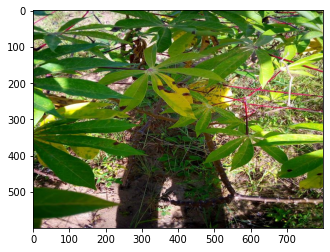

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(pathw):
    im_bgr = cv2.imread(pathw)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

img = get_img('input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

## Dataset

In [ ]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CassavaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

## Define Training and Validation Image Augmentations

In [ ]:
def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

## Model

In [ ]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        #n_features = self.model.classifier.in_features
        #self.model.classifier = nn.Linear(n_features, n_class)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Training APIs

In [ ]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='input/cassava-leaf-disease-classification/train_images/'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels)
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

In [ ]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

## Main Training Loop

In [ ]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print('\nTraining with fold {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root='input/cassava-leaf-disease-classification/train_images/')

        device = torch.device(CFG['device'])
        
        model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        
        for epoch in range(CFG['epochs']):
            train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

            with torch.no_grad():
                valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

            torch.save(model.state_dict(),'output/{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
            
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

Training with 0 started
17117 4280


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth
epoch 0 loss: 0.4632: 100%|██████████| 134/134 [18:58<00:00,  8.49s/it]


validation multi-class accuracy = 0.8395


epoch 1 loss: 0.4598: 100%|██████████| 134/134 [00:12<00:00, 10.43it/s]


validation multi-class accuracy = 0.8416


epoch 2 loss: 0.4733: 100%|██████████| 134/134 [00:12<00:00, 10.67it/s]


validation multi-class accuracy = 0.8339


epoch 3 loss: 0.4320: 100%|██████████| 134/134 [00:12<00:00, 10.77it/s]


validation multi-class accuracy = 0.8488


epoch 4 loss: 0.4827: 100%|██████████| 134/134 [00:12<00:00, 10.59it/s]


validation multi-class accuracy = 0.8325


epoch 5 loss: 0.4203: 100%|██████████| 134/134 [00:12<00:00, 10.48it/s]


validation multi-class accuracy = 0.8563


epoch 6 loss: 0.4085: 100%|██████████| 134/134 [00:12<00:00, 10.60it/s]


validation multi-class accuracy = 0.8633


epoch 7 loss: 0.3995: 100%|██████████| 134/134 [00:12<00:00, 10.55it/s]


validation multi-class accuracy = 0.8631


epoch 8 loss: 0.4036: 100%|██████████| 134/134 [00:12<00:00, 10.51it/s]


validation multi-class accuracy = 0.8682


epoch 9 loss: 0.4011: 100%|██████████| 134/134 [00:12<00:00, 10.67it/s]


validation multi-class accuracy = 0.8680
Training with 1 started
17117 4280


epoch 0 loss: 0.5591: 100%|██████████| 134/134 [00:12<00:00, 10.73it/s]


validation multi-class accuracy = 0.8042


epoch 1 loss: 0.4908: 100%|██████████| 134/134 [00:12<00:00, 10.65it/s]


validation multi-class accuracy = 0.8297


epoch 2 loss: 0.4817: 100%|██████████| 134/134 [00:12<00:00, 10.68it/s]


validation multi-class accuracy = 0.8278


epoch 3 loss: 0.4412: 100%|██████████| 134/134 [00:12<00:00, 10.72it/s]


validation multi-class accuracy = 0.8495


epoch 4 loss: 0.4576: 100%|██████████| 134/134 [00:12<00:00, 10.72it/s]


validation multi-class accuracy = 0.8411


epoch 5 loss: 0.4520: 100%|██████████| 134/134 [00:12<00:00, 10.74it/s]


validation multi-class accuracy = 0.8456


epoch 6 loss: 0.4127: 100%|██████████| 134/134 [00:12<00:00, 10.75it/s]


validation multi-class accuracy = 0.8645


epoch 7 loss: 0.4188: 100%|██████████| 134/134 [00:12<00:00, 10.81it/s]


validation multi-class accuracy = 0.8629


epoch 8 loss: 0.4252: 100%|██████████| 134/134 [00:12<00:00, 10.69it/s]


validation multi-class accuracy = 0.8624


epoch 9 loss: 0.4236: 100%|██████████| 134/134 [00:12<00:00, 10.33it/s]


validation multi-class accuracy = 0.8617
Training with 2 started
17118 4279


epoch 0 loss: 0.4788: 100%|██████████| 134/134 [00:12<00:00, 10.80it/s]


validation multi-class accuracy = 0.8350


epoch 1 loss: 0.4367: 100%|██████████| 134/134 [00:12<00:00, 10.78it/s]


validation multi-class accuracy = 0.8451


epoch 2 loss: 0.4629: 100%|██████████| 134/134 [00:12<00:00, 10.61it/s]


validation multi-class accuracy = 0.8411


epoch 3 loss: 0.4582: 100%|██████████| 134/134 [00:12<00:00, 10.63it/s]


validation multi-class accuracy = 0.8385


epoch 4 loss: 0.4337: 100%|██████████| 134/134 [00:12<00:00, 10.83it/s]


validation multi-class accuracy = 0.8495


epoch 5 loss: 0.4271: 100%|██████████| 134/134 [00:12<00:00, 10.63it/s]


validation multi-class accuracy = 0.8551


epoch 6 loss: 0.4387: 100%|██████████| 134/134 [00:12<00:00, 10.73it/s]


validation multi-class accuracy = 0.8523


epoch 7 loss: 0.4054: 100%|██████████| 134/134 [00:12<00:00, 10.57it/s]


validation multi-class accuracy = 0.8612


epoch 8 loss: 0.4136: 100%|██████████| 134/134 [00:12<00:00, 10.69it/s]


validation multi-class accuracy = 0.8602


epoch 9 loss: 0.4146: 100%|██████████| 134/134 [00:12<00:00, 10.62it/s]


validation multi-class accuracy = 0.8605
Training with 3 started
17118 4279


epoch 0 loss: 0.4781: 100%|██████████| 134/134 [00:12<00:00, 10.75it/s]


validation multi-class accuracy = 0.8334


epoch 1 loss: 0.4739: 100%|██████████| 134/134 [00:12<00:00, 10.78it/s]


validation multi-class accuracy = 0.8404


epoch 2 loss: 0.4793: 100%|██████████| 134/134 [00:12<00:00, 10.68it/s]


validation multi-class accuracy = 0.8231


epoch 3 loss: 0.4619: 100%|██████████| 134/134 [00:12<00:00, 10.65it/s]


validation multi-class accuracy = 0.8430


epoch 4 loss: 0.4227: 100%|██████████| 134/134 [00:12<00:00, 10.58it/s]


validation multi-class accuracy = 0.8504


epoch 5 loss: 0.4433: 100%|██████████| 134/134 [00:12<00:00, 10.52it/s]


validation multi-class accuracy = 0.8439


epoch 6 loss: 0.4353: 100%|██████████| 134/134 [00:12<00:00, 10.70it/s]


validation multi-class accuracy = 0.8493


epoch 7 loss: 0.4274: 100%|██████████| 134/134 [00:12<00:00, 10.51it/s]


validation multi-class accuracy = 0.8532


epoch 8 loss: 0.4125: 100%|██████████| 134/134 [00:12<00:00, 10.69it/s]


validation multi-class accuracy = 0.8619


epoch 9 loss: 0.4130: 100%|██████████| 134/134 [00:12<00:00, 10.57it/s]


validation multi-class accuracy = 0.8614
Training with 4 started
17118 4279


epoch 0 loss: 0.4965: 100%|██████████| 134/134 [00:12<00:00, 10.70it/s]


validation multi-class accuracy = 0.8301


epoch 1 loss: 0.4922: 100%|██████████| 134/134 [00:12<00:00, 10.75it/s]


validation multi-class accuracy = 0.8317


epoch 2 loss: 0.4571: 100%|██████████| 134/134 [00:12<00:00, 10.77it/s]


validation multi-class accuracy = 0.8425


epoch 3 loss: 0.4115: 100%|██████████| 134/134 [00:12<00:00, 10.76it/s]


validation multi-class accuracy = 0.8581


epoch 4 loss: 0.4207: 100%|██████████| 134/134 [00:12<00:00, 10.79it/s]


validation multi-class accuracy = 0.8574


epoch 5 loss: 0.4442: 100%|██████████| 134/134 [00:12<00:00, 10.71it/s]


validation multi-class accuracy = 0.8481


epoch 6 loss: 0.3966: 100%|██████████| 134/134 [00:12<00:00, 10.72it/s]


validation multi-class accuracy = 0.8640


epoch 7 loss: 0.4010: 100%|██████████| 134/134 [00:12<00:00, 10.96it/s]


validation multi-class accuracy = 0.8670


epoch 8 loss: 0.3955: 100%|██████████| 134/134 [00:12<00:00, 10.88it/s]


validation multi-class accuracy = 0.8687


epoch 9 loss: 0.3945: 100%|██████████| 134/134 [00:12<00:00, 10.67it/s]


validation multi-class accuracy = 0.8668


# Save Trained Checkpoints to Drive

In [ ]:
%cd ..

!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_0 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_1 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_2 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_3 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_4 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_5 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_6 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_7 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_8 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_0_9 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_0

/content


In [ ]:
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_0 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_1 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_2 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_3 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_4 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_5 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_6 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_7 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_8 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_1_9 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_1

In [ ]:
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_0 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_1 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_2 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_3 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_4 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_5 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_6 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_7 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_8 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_2_9 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_2

In [ ]:
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_0 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_1 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_2 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_3 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_4 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_5 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_6 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_7 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_8 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_3_9 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_3

In [ ]:
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_0 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_1 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_2 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_3 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_4 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_5 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_6 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_7 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_8 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4
!cp -r /content/Cassava-Leaf-Disease/output/vit_base_patch16_224_fold_4_9 drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output/fold_4